# Análisis de la red de *tweets* y usuarios relacionados con la final de la Liga Uruguaya de Basketball (LUB).






## Trabajo final del curso "De las redes complejas a las redes sociales: Introducción al Uso del Big Data"


### Integrantes del equipo: 

- Andrea Apolaro
- Guzmán López
- Leticia Vidal
- Ricardo Rezzano


## Introducción

En el marco del curso ...



## Metodología

Se utilizó el lenguaje de programación Python (versión 3.6.1) ...

Importar librerías 

In [23]:
# Import python libraries
import tweepy
import time
from random import choice
from py2neo import authenticate, Graph
import cypher
import networkx as nx
import matplotlib.pyplot as plt

Autenticación de Twitter y Neo4j mediante la lectura de un archivo externo con las claves requeridas:

In [8]:
import tweepy

# Twitter OAuthentication
consumer_key = "XXXXXXXXXX"
consumer_secret = "XXXXXXXXXX"
access_token = "XXXXXXXXXX"
access_token_secret = "XXXXXXXXXX"

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

# Neo4j
neo4jUser = "xxxx"
neo4jPass = "xxxx"

In [2]:
# Authentication credentials for Tweeter and Neo4j credentials
with open('/home/guzman/Documentos/Cursos/Redes Complejas - Introducción al uso del Big Data/Python/twitter-OAuth.py') as oauth:
    exec(oauth.read())

Crear la API (Application Program Interface) de Twitter:

In [10]:
# Create API
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True, compression=True)

Comenzar el servicio de la base de datos Neo4j desde una consola:

In [4]:
%%sh

# Start neo4j service 
systemctl start neo4j.service

# Check status of neo4j service
systemctl status neo4j.service

● neo4j.service - Neo4j
   Loaded: loaded (/usr/lib/systemd/system/neo4j.service; disabled; vendor preset: disabled)
   Active: active (running) since Mon 2017-06-05 23:56:39 -03; 4ms ago
  Process: 3064 ExecStart=/usr/bin/neo4j start (code=exited, status=0/SUCCESS)
 Main PID: 3124 (java)
    Tasks: 41 (limit: 4915)
   Memory: 22.8M
      CPU: 132ms
   CGroup: /system.slice/neo4j.service
           └─3124 /usr/sbin/java -cp /usr/share/java/neo4j/plugins:/etc/neo4j:/usr/share/java/neo4j/*:/usr/share/java/neo4j/plugins/* -server -XX:+UseG1GC -XX:-OmitStackTraceInFastThrow -XX:hashCode=5 -XX:+AlwaysPreTouch -XX:+UnlockExperimentalVMOptions -XX:+TrustFinalNonStaticFields -XX:+DisableExplicitGC -Djdk.tls.ephemeralDHKeySize=2048 -Dunsupported.dbms.udc.source=tarball -Dfile.encoding=UTF-8 org.neo4j.server.CommunityEntryPoint --home-dir=/usr/share/neo4j --config-dir=/etc/neo4j

jun 05 23:56:39 carqueja systemd[1]: Starting Neo4j...
jun 05 23:56:39 carqueja neo4j[3064]: Starting Neo4j.
jun 05 2

Autenticación de la base de datos no relacional Neo4j a través de la lectura del archivo externo con las claves de usuario y contraseña requeridas leído anteriormente.

In [4]:
# Neo4j DB graph authentication

# Connect to graph
url = "http://localhost:7474/db/data/"
authenticate("localhost:7474", neo4jUser, neo4jPass)
graph = Graph(url)

# Authentication for cypher package
connPar = "http://" + neo4jUser + ":" + neo4jPass + "@localhost:7474/db/data/"

Agregar restricciones de unicidad a la base de datos:

In [ ]:
# Add uniqueness constraints
graph.run("CREATE CONSTRAINT ON (t:Tweet) ASSERT t.id IS UNIQUE;")
graph.run("CREATE CONSTRAINT ON (u:User) ASSERT u.screen_name IS UNIQUE;")
graph.run("CREATE CONSTRAINT ON (h:Hashtag) ASSERT h.name IS UNIQUE;")
graph.run("CREATE CONSTRAINT ON (l:Link) ASSERT l.url IS UNIQUE;")
graph.run("CREATE CONSTRAINT ON (s:Source) ASSERT s.name IS UNIQUE;")

Construir una lista con las palabras clave para la búsqueda de tweets:

In [16]:
# Query words
queries = ["aguada", "aguatero", "hebraica", "macabi", "finalesLUB", "juntosporlanovena", "vamossha", "finaleslub"]

Crear un archivo de texto vacío para adjuntar (escribir) los nombres de los usuarios de los tweets encontrados:

In [ ]:
# Open file connection to append usernames
ufile = open("usernames_{}.txt".format("aguada-hebraica"), "a")

Cargar script de comandos en Cypher como cadena de caracteres

In [ ]:
# Pass dict to Cypher and build query from cypher script file
with open('/home/guzman/Documentos/GitLab/ComplexNetworks/Cypher/queries-in-script.cypher') as query:
    query = query.read()

print(query)

Definir los parámetros para la búsqueda de los tweets:

In [ ]:
# Parameters
count = 100 # The number of tweets to return per page, up to a maximum of 100. Defaults to 15.
result_type = "mixed" # Include both popular and real time results in the response.
until = "2017-06-04" # Returns tweets created before the given date.
lang = "es" # Restricts tweets to the given language
since_id = -1 # Returns results with an ID greater than (that is, more recent than) the specified ID.

Definir una función para la búsqueda de tweets que contiene la función de búsqueda de tweets de la librería tweepy y recibe como parámetros las palabras clave de búsqueda y el ID.

In [ ]:
def search_tweets(query, since_id):
    return api.search(q=query, count=count, until=until, result_type=result_type, lang=lang, since_id=since_id)

Iterar buscando tweets a partir de las palabras claves en la búsqueda y ejecutando el código importado en Cypher para insertar los registros en la base de datos no relacional de Neo4j. 

In [ ]:
while True:
    try:
        q = choice(queries)
        tweets = search_tweets(q, since_id)
        if tweets:
            plural = "s." if len(tweets) > 1 else "."
            print("Found " + str(len(tweets)) + " tweet" + plural)
        else:
            print("No tweets found.\n")
            time.sleep(65)
            continue
        
        since_id = tweets[0].id

        # Send Cypher query.
        graph.run(query, tweets=[tweet._json for tweet in tweets])

        # adding users to user list
        for tweet in tweets:
            ufile.write(tweet.user.screen_name+"\n")
        print("Tweets added to graph! \n")
        time.sleep(33)

    except Exception as e:
        print(e)
        time.sleep(33)
        continue

Import graph to python

In [6]:
# Import graph to python - queries
# https://nicolewhite.github.io/neo4j-jupyter/hello-world.html

# Return all the nodes in the DB
# data = graph.run('')

data = graph.run('MATCH usPostw=(:User)-[r:POSTS]->(:Tweet) \
                  MATCH twRettw=(:Tweet)-[r2:RETWEETS]->(:Tweet) \
                  MATCH twReptw=(:Tweet)-[r3:REPLY_TO]->(:Tweet) \
                  MATCH twMenus=(:Tweet)-[r4:MENTIONS]->(:User) \
                  RETURN usPostw,twRettw,twReptw,twMenus \
                  LIMIT 10000;')

data = [tuple(x) for x in data]

# View first five graphs
i = 0
for i in range(0,5):
    print(str(i + 1) + " - " + str(data[i]) + "\n")
    i = i + 1

1 - ((e7d8479)-[:POSTS]->(cf0a24e), (f949b73)-[:RETWEETS]->(b306a18), (e06876d)-[:REPLY_TO]->(a03511b), (f949b73)-[:MENTIONS]->(e7d8479))

2 - ((e7d8479)-[:POSTS]->(cf0a24e), (f949b73)-[:RETWEETS]->(b306a18), (e06876d)-[:REPLY_TO]->(a03511b), (f949b73)-[:MENTIONS]->(de94de1))

3 - ((e7d8479)-[:POSTS]->(cf0a24e), (f949b73)-[:RETWEETS]->(b306a18), (e06876d)-[:REPLY_TO]->(a03511b), (b306a18)-[:MENTIONS]->(de94de1))

4 - ((e7d8479)-[:POSTS]->(cf0a24e), (f949b73)-[:RETWEETS]->(b306a18), (e06876d)-[:REPLY_TO]->(a03511b), (e3cc96b)-[:MENTIONS]->(b91061a))

5 - ((e7d8479)-[:POSTS]->(cf0a24e), (f949b73)-[:RETWEETS]->(b306a18), (e06876d)-[:REPLY_TO]->(a03511b), (bfc1894)-[:MENTIONS]->(b91061a))



Crear objeto de grafos a partir de consulta a la base de datos Neo4j y ver su información:

In [5]:
# Query Neo4j
results = cypher.run('MATCH usPostw=(:User)-[r:POSTS]->(:Tweet) \
                      MATCH twRettw=(:Tweet)-[r2:RETWEETS]->(:Tweet) \
                      MATCH twReptw=(:Tweet)-[r3:REPLY_TO]->(:Tweet) \
                      MATCH twMenus=(:Tweet)-[r4:MENTIONS]->(:User) \
                      RETURN usPostw,twRettw,twReptw,twMenus \
                      LIMIT 100000;', conn=connPar)

# Create graph object from Neo4j
g = results.get_graph()

# View info
print(nx.info(g))

100000 rows affected.
Name: 
Type: MultiDiGraph
Number of nodes: 267
Number of edges: 366
Average in degree:   1.3708
Average out degree:   1.3708


Graficar el objeto de grafos:

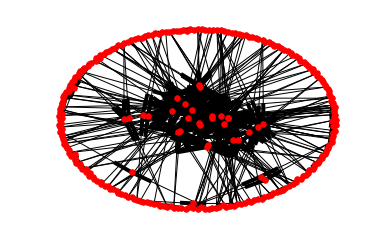

In [6]:
%matplotlib inline

# Create network layout for visualizations
spring_pos = nx.spring_layout(g)

# Plot graph
plt.axis("off")
nx.draw_networkx(g, pos = spring_pos, with_labels = False, node_size = 30)


/usr/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/usr/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/usr/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/usr/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


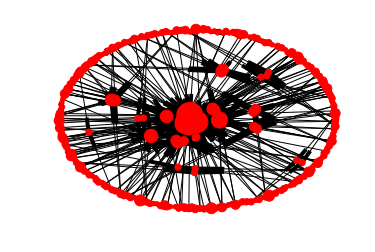

In [36]:
%matplotlib inline

d = nx.degree(g)

# Create network layout for visualizations
spring_pos = nx.spring_layout(g)

# Plot graph
plt.axis("off")
nx.draw(g, pos = spring_pos, with_labels = False, nodelist=d.keys(), node_size=[v * 20 for v in d.values()])


Ver nodos:

In [18]:
# View first five nodes
i = 0
for i in range(0,5):
    print(str(i + 1) + "- " + str(g.nodes(data=True)[i]))
    i = i + 1

1- ('0', {'favorites': 2, 'created_at': 'Wed May 31 21:03:11 +0000 2017', 'id': 870022870512152577, 'text': 'tamos ahí @sandynyordi #JuntosPorLaNovena https://t.co/x2kWrWLrS2', 'labels': ['Tweet']})
2- ('1', {'favorites': 0, 'created_at': 'Wed May 31 21:14:07 +0000 2017', 'id': 870025622801838080, 'text': 'RT @KarinaAguatera: tamos ahí @sandynyordi #JuntosPorLaNovena https://t.co/x2kWrWLrS2', 'labels': ['Tweet']})
3- ('2', {'favorites': 1, 'created_at': 'Wed May 31 21:24:58 +0000 2017', 'id': 870028352631054336, 'text': 'mi trabajo de parto duro menos q sacar las entradas para la última final. #JuntosPorLaNovena', 'labels': ['Tweet']})
4- ('100', {'followers': 190, 'screen_name': 'KarinaAguatera', 'following': 964, 'name': '@JAKCARBONEROS', 'statuses': 1725, 'profile_image_url': 'http://pbs.twimg.com/profile_images/871221543908638720/x4FSyHJs_normal.jpg', 'location': 'montevideo', 'labels': ['User']})
5- ('4', {'favorites': 1, 'created_at': 'Thu Jun 01 13:37:06 +0000 2017', 'id': 87027

Ver ejes:

In [19]:
# View first five edges
i = 0
for i in range(0,5):
    print(str(i + 1) + "- " + str(g.edges(data=True)[i]))
    i = i + 1

1- ('0', '101', {'type': 'MENTIONS'})
2- ('1', '100', {'type': 'MENTIONS'})
3- ('1', '0', {'type': 'RETWEETS'})
4- ('1', '101', {'type': 'MENTIONS'})
5- ('100', '2', {'type': 'POSTS'})


Calcular principales métricas de los grafos:

In [27]:
# Degrees (max, min, mean)
deg = nx.degree(g)

# Número de nodos y ejes
numNod = nx.number_of_nodes(g)
numEdg = nx.number_of_edges(g)

# Componentes conectados
#conComp = nx.number_connected_components(g)

# Componentes conexas
#cns = nx.connected_components(g)

# Diámetro
#d = nx.diameter(g)

# Excentricidad
#ecc = nx.eccentricity(g)

# Centro
#cen = nx.center(g)

# Periferia
#per = nx.periphery(g)

# Transistividad
#tr = nx.transitivity(g)

# Resumen
print("| Grado máximo:", str(max(deg.values())))
print("| Grado mínimo:", str(min(deg.values())))
print("| Grado promedio:", str(sum(deg.values())/len(deg.values())))

print("| Número de nodos:", str(numNod))
print("| Número de conexiones:", str(numEdg))

#print("componentes conexas: ", cns)
#print("diameter: %s" % d)
#print("eccentricity: %s" % ecc)
#print("center: %s" % cen)
#print("periphery: %s" % per)

# 3d visualization
#import jgraph
#jgraph.draw(data)

| Grado máximo: 34
| Grado mínimo: 1
| Grado promedio: 2.741573033707865
| Número de nodos: 267
| Número de conexiones: 366


Detectar comunidades:

In [9]:
import community

parts = community.best_partition(g)
#values = [parts.get(node) for node in g.nodes()]

#plt.axis("off")
#nx.draw_networkx(g, pos = spring_pos, cmap = plt.get_cmap("jet"), node_color = values, node_size = 35, with_labels = False)


TypeError: Bad graph type, use only non directed graph